# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 20.10.2020

Мягкий дедлайн: 01:59MSK 02.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 01:59MSK 05.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [3]:
#your code here
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve

In [4]:
#C = [0.01,0.05,0.1,0.15,1,10,100,500,1000,1500]
C = np.logspace(0, 5, 10)

In [5]:
grid = GridSearchCV(Pipeline(steps=[('scaler', StandardScaler()),
                                    ('model', SVC(kernel='linear',max_iter=10000))]),
                    param_grid={'model__C' : C}, cv=3)
grid.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        SVC(kernel='linear', max_iter=10000))]),
             param_grid={'model__C': array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05])})

Text(0, 0.5, 'CV score')

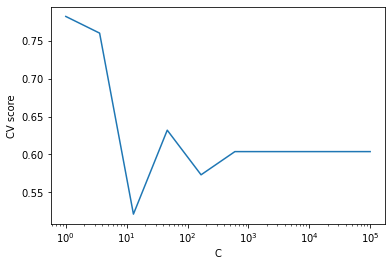

In [6]:
plt.plot(C, grid.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")

In [7]:
C_best = grid.best_params_['model__C']
#print(C_best)
clf = Pipeline(steps=[('scaler',StandardScaler()),
                      ('model', SVC(kernel='linear', max_iter = 10000, C=C_best))])
clf.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(kernel='linear', max_iter=10000))])

На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

In [8]:
#your code here
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label='SVM')
    plt.title('SVM ROC AUC = %0.6f' %
              roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    plt.figure()
    
    
    plt.plot([0, 1],[0.5,0.5],linestyle='--',label='Случайный классификатор')
    plt.plot(recall, precision,label='SVM')
    plt.title('SVM PR = %0.6f'% auc(recall, precision))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0,1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

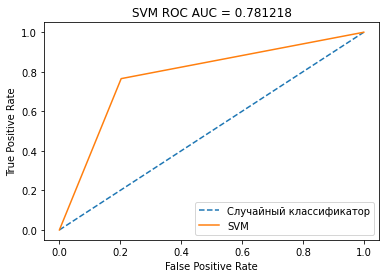

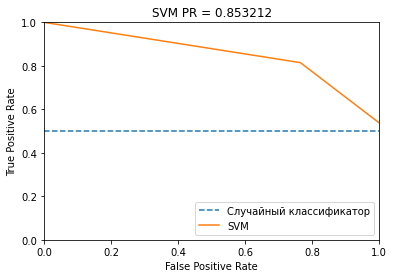

In [9]:
show_roc_curve(clf.predict(X_test),y_test)

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [10]:
#your code here
from sklearn.linear_model import LogisticRegression

In [11]:
C = np.logspace(-20, 5, 15)

In [12]:
grid = GridSearchCV(Pipeline(steps=[('scaler', StandardScaler()),
                                    ('model', LogisticRegression())]),
                    param_grid={'model__C' : C}, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': array([1.00000000e-20, 6.10540230e-19, 3.72759372e-17, 2.27584593e-15,
       1.38949549e-13, 8.48342898e-12, 5.17947468e-10, 3.16227766e-08,
       1.93069773e-06, 1.17876863e-04, 7.19685673e-03, 4.39397056e-01,
       2.68269580e+01, 1.63789371e+03, 1.00000000e+05])})

Text(0, 0.5, 'CV score')

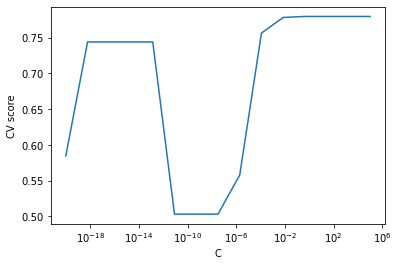

In [13]:
plt.plot(C, grid.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")

In [14]:
C_best = grid.best_params_['model__C']

linreg = Pipeline(steps=[('scaler', StandardScaler()),
                         ('model', LogisticRegression(C=C_best))])
linreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=26.826957952797382))])

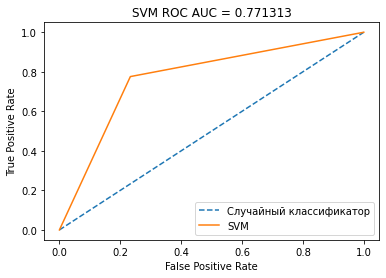

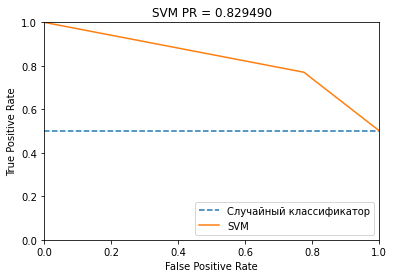

In [15]:
show_roc_curve(linreg.predict(X_test), y_test)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [69]:
#your code here

from sklearn import datasets

X, y = datasets.make_blobs(n_samples=10000, centers=2, n_features=2, center_box=(0, 10), random_state=42)

In [70]:
model = SVC(kernel='linear')
model.fit(X, y)


SVC(kernel='linear')

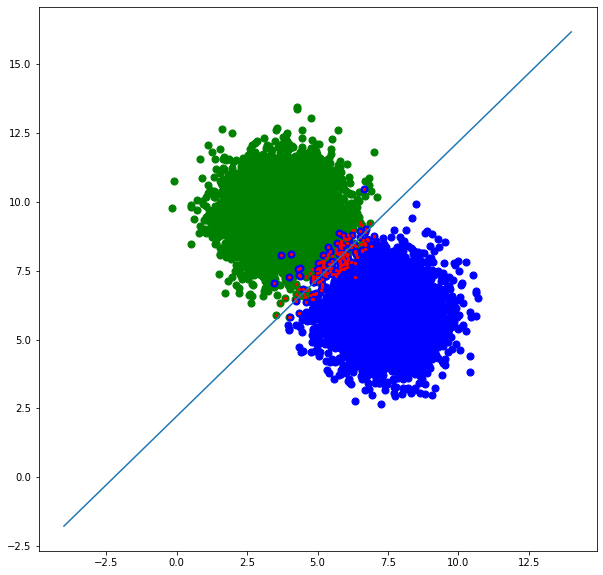

In [72]:
plt.figure(figsize=[10,10])
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='g',s=50)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='b',s=50)
plt.scatter(model.support_vectors_[:, 0],
            model.support_vectors_[:, 1], color='r', s=5)
xx = np.linspace(-4, 14)
yy = -model.coef_[0][0]/model.coef_[0][1] * xx - model.intercept_[0]/model.coef_[0][1]
plt.plot(xx, yy)


# xx = np.linspace(-1, max(X + 1, len(X))
# yy = np.linspace(0, max(y + 1, len(y))
# YY, XX = np.meshgrid(yy, xx)
# xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Z = model.decision_function(xy).reshape(XX.shape)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

<ipython-input-19-180fd1dae0df>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(xx,yy,pred)


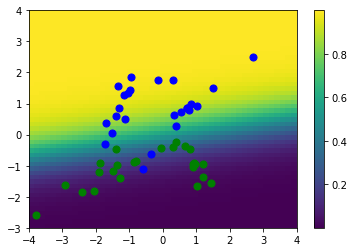

In [19]:
# your code here
model = LogisticRegression()
model.fit(X, y)
xx = np.linspace(-4, 4)
yy = np.linspace(-3, 4)
all_x = np.meshgrid(xx, yy)[0].flatten()
all_y = np.meshgrid(xx, yy)[1].flatten()
xy = np.vstack((all_x, all_y)).T
pred = np.array(model.predict_proba(xy)[:,1]).reshape((50,50))
plt.pcolor(xx,yy,pred)
plt.colorbar()


plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='g', s=50)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='b', s=50)





__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [20]:
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)  # 1
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (
            preds < r)] == 1) / y_test[(preds >= l) & (preds < r)].shape)  # 2
    plt.figure(figsize=(6, 6))
    plt.title(name)
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.ylabel('True positive rate')
    

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [21]:
def plot_hist(y_test, preds, name):
    plt.figure(figsize=(6, 6))
    plt.hist(np.array([pred[y_test==0], pred[y_test==1]]),label=['class_0','class_1'])
    plt.grid()
    plt.legend()
    plt.title(name)
    plt.xlabel('Proba')
    plt.ylabel('Freq')

<ipython-input-21-d43286d084aa>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array([pred[y_test==0], pred[y_test==1]]),label=['class_0','class_1'])
<ipython-input-21-d43286d084aa>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array([pred[y_test==0], pred[y_test==1]]),label=['class_0','class_1'])


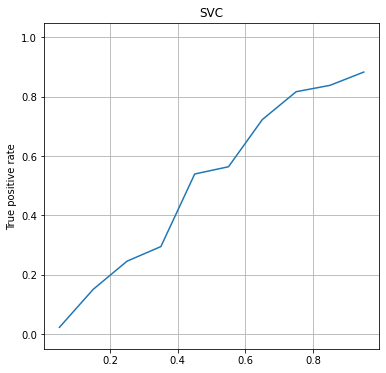

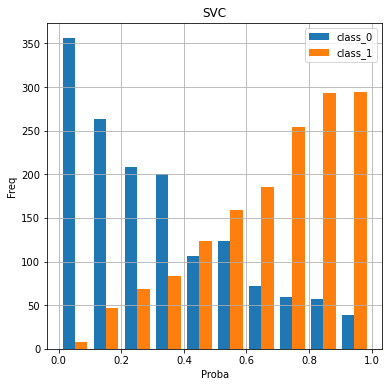

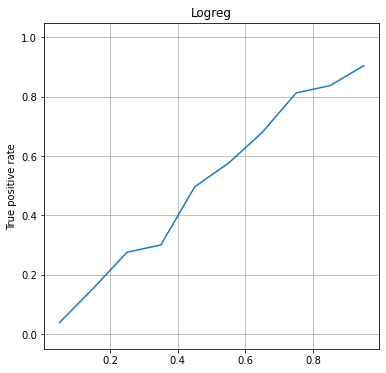

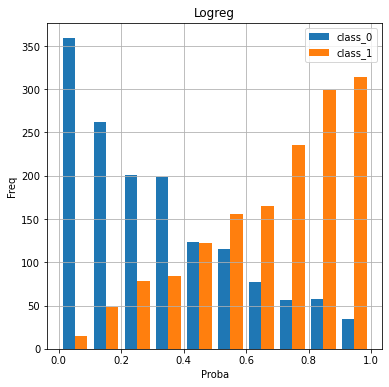

In [22]:
models = [(SVC(kernel='linear',probability=True),'SVC'), (LogisticRegression(), 'Logreg')]

for model, name in models:
    model.fit(X_train,y_train)
    pred = model.predict_proba(X_test)[:,1]
    plot_calibration_curve(y_test,pred,name)
    plot_hist(y_test, pred, name)

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

НИЧЕГО ОСОБЕННОГО НЕ ПОМЕНЯЛОСЬ!

In [23]:
#your code here
from sklearn.calibration import CalibratedClassifierCV

<ipython-input-21-d43286d084aa>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array([pred[y_test==0], pred[y_test==1]]),label=['class_0','class_1'])


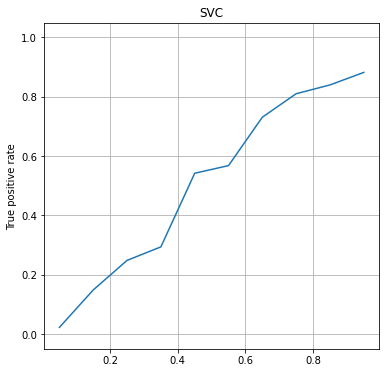

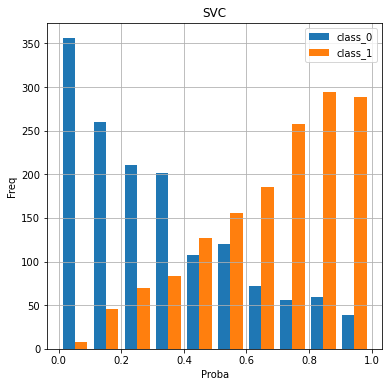

In [24]:
model = SVC(kernel='linear')
cal_model = CalibratedClassifierCV(model).fit(X_train, y_train)
pred = cal_model.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, pred, 'SVC')
plot_hist(y_test,pred,'SVC')

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [25]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [26]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2021-07-31 21:56:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 444572 (434K) [application/x-httpd-php]
Сохранение в: «bank-additional.zip.5»

bank-additional.zip 100%[===================>] 434,15K   439KB/s    за 1,0s    

2021-07-31 21:56:15 (439 KB/s) - «bank-additional.zip.5» сохранён [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [41]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [42]:
#your code here
X = df.drop(columns='y')
y = df.y.apply(lambda x: 0 if x=='no' else 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777, test_size=0.25,stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__:

In [43]:
#your code here
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric = X_train.select_dtypes([np.number]).columns

In [44]:
from sklearn.preprocessing import *
from sklearn.compose import ColumnTransformer

def AUC_PR(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    print(auc(recall, precision))

In [45]:
%time
column_transformer = ColumnTransformer(
    [('column_transform',  OrdinalEncoder(),categorical)])
pipe = Pipeline(steps=[
    ('Ordinal_Encoder', column_transformer),
    ('regression', LogisticRegression())])
pipe.fit(X_train, y_train)
AUC_PR(y_test, pipe.predict_proba(X_test)[:,1])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
0.3064820299857385


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [46]:
#your code here
%time
column_transformer = ColumnTransformer(
    [('column_transform', OneHotEncoder() ,categorical)])
pipe = Pipeline(steps=[
    ('Ordinal_Encoder', column_transformer),
    ('regression', LogisticRegression())])
pipe.fit(X_train, y_train)
AUC_PR(y_test, pipe.predict_proba(X_test)[:,1])

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 3.81 µs
0.4069681417384294


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [47]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin

In [48]:
class My_Counter(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.target = None
        self.my_dict = {}

    def fit(self,X, y):
        X = X.copy()
        y = y.copy()
        X['y'] = y
        self.target = list(y.unique())
        for column in self.columns:
            count = X.groupby(column, as_index=False)['y'].count()
            count_all = count['y'].sum()
            count['y'] /= count_all

            cur = {row[column]:row["y"] for index, row in count.iterrows()}
            self.my_dict.update({column:cur})
        return self
    
    def transform(self, X):
        X = X.copy()
        for column in self.columns:
            column_temp = self.my_dict[column]
            X[column] = X[column].map(column_temp).fillna(0)
        return X

In [49]:
#your code here
%time
column_transformer = ColumnTransformer(
    [('column_transform', My_Counter(categorical) ,categorical)])
pipe = Pipeline(steps=[
    ('Ordinal_Encoder', column_transformer),
    ('regression', LogisticRegression())])
pipe.fit(X_train, y_train)
AUC_PR(y_test, pipe.predict_proba(X_test)[:,1])

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.8 µs
0.2976863470133436


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [50]:
# your code here
class My_Counter_2(My_Counter):
    def __init__(self, columns, sigma, mu=0):
        self.columns = columns
        self.target = None
        self.my_dict = {}
        self.sigma = sigma
        self.mu = mu

    def transform(self, X):
        X = X.copy()
        for column in self.columns:
            column_temp = self.my_dict[column]
            X[column] = X[column].map(column_temp).fillna(0) + np.random.normal(self.mu,self.sigma,X.shape[0])
        return X

In [51]:
#your code here
%time
column_transformer = ColumnTransformer(
    [('column_transform', My_Counter_2(categorical,0.0001) ,categorical)])
pipe = Pipeline(steps=[
    ('Ordinal_Encoder', column_transformer),
    ('regression', LogisticRegression())])
pipe.fit(X_train, y_train)
AUC_PR(y_test, pipe.predict_proba(X_test)[:,1])

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 12.2 µs
0.29762685033864206


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [52]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [53]:
# your code here
class My_Counter_3(BaseEstimator, TransformerMixin):
    def __init__(self, columns, global_mean, c):
        self.columns = columns
        self.global_mean = global_mean
        self.c = c
        self.my_dict = {}

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()
        X['y'] = y
        self.target = list(y.unique())
        for column in self.columns:
            count = X.groupby(column, as_index=False)['y'].count()
            count_all = count['y'].sum()
            count['y'] = (count['y'] + self.c*self.global_mean) / \
                (count_all + self.c)

            cur = {row[column]: row["y"] for index, row in count.iterrows()}
            self.my_dict.update({column: cur})
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.columns:
            column_temp = self.my_dict[column]
            X[column] = X[column].map(column_temp).fillna(0)
        return X

In [54]:
priors = np.linspace(-1, 1, 20)
c = 10
best_model={'prior': 0, 'auc_pr':0}
for prior in priors:
    #your code here
    column_transformer = ColumnTransformer(
        [('column_transform', My_Counter_3(categorical,prior, 10), categorical)])
    pipe = Pipeline(steps=[
        ('Ordinal_Encoder', column_transformer),
        ('regression', LogisticRegression())])
    pipe.fit(X_train, y_train)
    print(AUC_PR(y_test, pipe.predict_proba(X_test)[:,1]),prior)


        
print('Best prior - {}'.format(best_model['prior']))
print('Best score - {}'.format(best_model['auc_pr']))

0.2976820322820422
None -1.0
0.29769901852116704
None -0.8947368421052632
0.29769755105714696
None -0.7894736842105263
0.297687150468828
None -0.6842105263157895
0.29769379075259267
None -0.5789473684210527
0.2976958203611449
None -0.4736842105263158
0.29768583066240817
None -0.368421052631579
0.2976901823253162
None -0.26315789473684215
0.29768786893202276
None -0.1578947368421053
0.2976986913762217
None -0.052631578947368474
0.2976896671674688
None 0.05263157894736836
0.2976982036983803
None 0.1578947368421053
0.2976941425189312
None 0.26315789473684204
0.2976759853624872
None 0.36842105263157876
0.2977034467534412
None 0.4736842105263157
0.2977022293403951
None 0.5789473684210527
0.2976974905020915
None 0.6842105263157894
0.2977055368969356
None 0.7894736842105261
0.2976936468881276
None 0.894736842105263
0.29769102048344565
None 1.0
Best prior - 0
Best score - 0


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [55]:
#your code here

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [56]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [57]:
#your code here
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric = X_train.select_dtypes([np.number]).columns

transfromer = ColumnTransformer([('OneHot', OneHotEncoder(), categorical)])
transfromer.fit(X_train)
X_train = transfromer.transform(X_train)
X_test = transfromer.transform(X_test)
print(X_train.shape)

(32950, 53)


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [58]:
#your code here
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test,LogReg.predict(X_test))
auc_pr = auc(recall,precision)
print('auc curve - {}'.format(auc_pr))

auc curve - 0.47846903224377857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как? 

Увеличилось!!!!



In [59]:
# your code here
table = pd.DataFrame({'w': np.array(np.abs(LogReg.coef_[0])), 'ind': [
                     i for i in range(X_train.shape[1])]}).sort_values('w', ascending=False)
w_index = table.iloc[:40]['ind'].values
X_train_best = X_train[:,w_index]
LogReg.fit(X_train_best, y_train)
precision, recall, thresholds = precision_recall_curve(y_test,LogReg.predict(X_test[:,w_index]))
auc_pr = auc(recall,precision)
print('auc curve - {}'.format(auc_pr))

auc curve - 0.47739357710334296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [60]:
# your code here
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y)

transfromer = ColumnTransformer(
    [('ohe', OneHotEncoder(), categorical), ('s_scaler', StandardScaler(), numeric)])
transfromer.fit(X_train)

X_train = transfromer.transform(X_train)
X_test = transfromer.transform(X_test)

LogReg = LogisticRegression()
LogReg.fit(X_train,y_train)
precision, recall, thresholds = precision_recall_curve(y_test,LogReg.predict(X_test))
auc_pr = auc(recall,precision)

table = pd.DataFrame({'w': np.array(np.abs(LogReg.coef_[0])), 'ind': [
                     i for i in range(X_train.shape[1])]}).sort_values('w', ascending=False)
w_index = table.iloc[:40]['ind'].values

print('auc curve all feat - {}'.format(auc_pr))

LogReg = LogisticRegression()
LogReg.fit(X_train[:,w_index],y_train)
precision, recall, thresholds = precision_recall_curve(y_test,LogReg.predict(X_test[:,w_index]))
auc_pr = auc(recall,precision)
print('auc curve 40 feat - {}'.format(auc_pr))

auc curve all feat - 0.4947794195921687
auc curve 40 feat - 0.4881040644021567


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [61]:
#your code here

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [62]:
# your code here
def filter(X_train, y_train, number_features=40):
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]

    t_num = np.abs(np.mean(X_train_pos, axis=0) - np.mean(X_train_neg,axis=0))
    t_den = (np.std(X_train_pos,axis=0) ** 2 * X_train_pos.shape[0]) + (
        (np.std(X_train_neg, axis=0) ** 2 * X_train_neg.shape[0])) / (X_train.shape[0])

    t = t_num / t_den
    table = pd.DataFrame({'t': np.array(np.abs(t)), 'ind': [
                     i for i in range(X_train.shape[1])]}).sort_values('t', ascending=False)
    w_index = table.iloc[:number_features]['ind'].values

    return w_index

In [63]:
%time
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y)

transfromer = ColumnTransformer(
    [('ohe', OneHotEncoder(), categorical), ('s_scaler', StandardScaler(), numeric)])
transfromer.fit(X_train)
X_train = transfromer.transform(X_train)
X_test = transfromer.transform(X_test)
indexes = filter(X_train,y_train)
LogReg = LogisticRegression()
LogReg.fit(X_train[:,indexes],y_train)
precision, recall, thresholds = precision_recall_curve(y_test,LogReg.predict(X_test[:,indexes]))
auc_pr = auc(recall,precision)
print(auc_pr)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.06 µs
0.4978975151148308


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [64]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [65]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [86]:
#your code here
from sklearn.model_selection import  KFold

In [87]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

X = column_transformer.fit_transform(X)

In [102]:
kfold = KFold(shuffle=True, random_state=500)
revenues = []
costs = []
profit = []
value = 10

for train_ind, test_ind in kfold.split(X):
    X_train, y_train = X[train_ind, :], y[train_ind]
    X_test, y_test = X[test_ind, :], y[test_ind]

    LogReg = LogisticRegression(max_iter=100000)
    LogReg.fit(X_train, y_train)
    pred = LogReg.predict(X_test)

    revenues.append(value * np.sum(pred * y_test))
    costs.append(np.sum(pred))
    profit.append(value * np.sum(pred * y_test)-np.sum(pred))

table = pd.DataFrame(np.array([revenues, costs, profit]).T, columns=[
                     'revenue', 'costs', 'profit'])
print('Cредний доход {}'.format(np.mean(table.profit)))
print('Sigma доход {}'.format(np.std(table.profit)))
table.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


Cредний доход 1805.8
Sigma доход 108.67640038205167


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


,revenue,costs,profit
0,2240,310,1930
1,2110,330,1780
2,2090,330,1760
3,2250,330,1920
4,1960,321,1639


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [116]:
#your code here
kfold = KFold(shuffle=True)
revenues=[]
costs=[]
profit=[]

for train_ind, test_ind in kfold.split(X):
    X_train, y_train = X[train_ind,:], y[train_ind]
    X_test, y_test = X[test_ind,:], y[test_ind]
    
    LogReg = LogisticRegression(max_iter=100000)
    LogReg.fit(X_train, y_train)
    pred = LogReg.predict(X_test)
    value = np.random.randint(low = 0, high = 21, size=y_test.shape)
    revenues.append(np.sum(value * pred * y_test))
    costs.append(np.sum(pred))
    profit.append(np.sum(value * pred * y_test)-np.sum(pred))

table = pd.DataFrame(np.array([revenues,costs,profit]).T,columns=['revenue', 'costs', 'profit'])
print('Cредний доход {}'.format(np.mean(table.profit)))
print('Sigma доход {}'.format(np.std(table.profit)))
table.head()



Cредний доход 1785.0
Sigma доход 44.07720499305735


,revenue,costs,profit
0,2143,316,1827
1,2067,331,1736
2,2148,310,1838
3,2069,336,1733
4,2107,316,1791


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [141]:
# your code here
c = np.logspace(-1, 3, 4)
std = []
avg_profit = []
C = []
for i in c:
    revenues = []
    costs = []
    profit = []
    for train_ind, test_ind in kfold.split(X):
        X_train, y_train = X[train_ind, :], y[train_ind]
        X_test, y_test = X[test_ind, :], y[test_ind]

        LogReg = LogisticRegression(max_iter=100000, C=i)
        LogReg.fit(X_train, y_train)
        pred = LogReg.predict(X_test)
        value = np.random.randint(low=0, high=21, size=y_test.shape)
        revenues.append(np.sum(value * pred * y_test))
        costs.append(np.sum(pred))
        profit.append(np.sum(value * pred * y_test)-np.sum(pred))
    avr_profit=np.mean(profit)
    std_profit=np.std(profit)
    std.append(std_profit)
    avg_profit.append(avr_profit)

    print('C=', i, 'avr_profit=',avr_profit, 'std_profit=',std_profit)

C= 0.1 avr_profit= 1769.8 std_profit= 46.95274219893871
C= 2.1544346900318834 avr_profit= 1792.6 std_profit= 99.51602885967667
C= 46.41588833612777 avr_profit= 1820.8 std_profit= 134.3940474872306
C= 1000.0 avr_profit= 1787.4 std_profit= 208.36947953095242


Text(0, 0.5, 'Mean_pr')

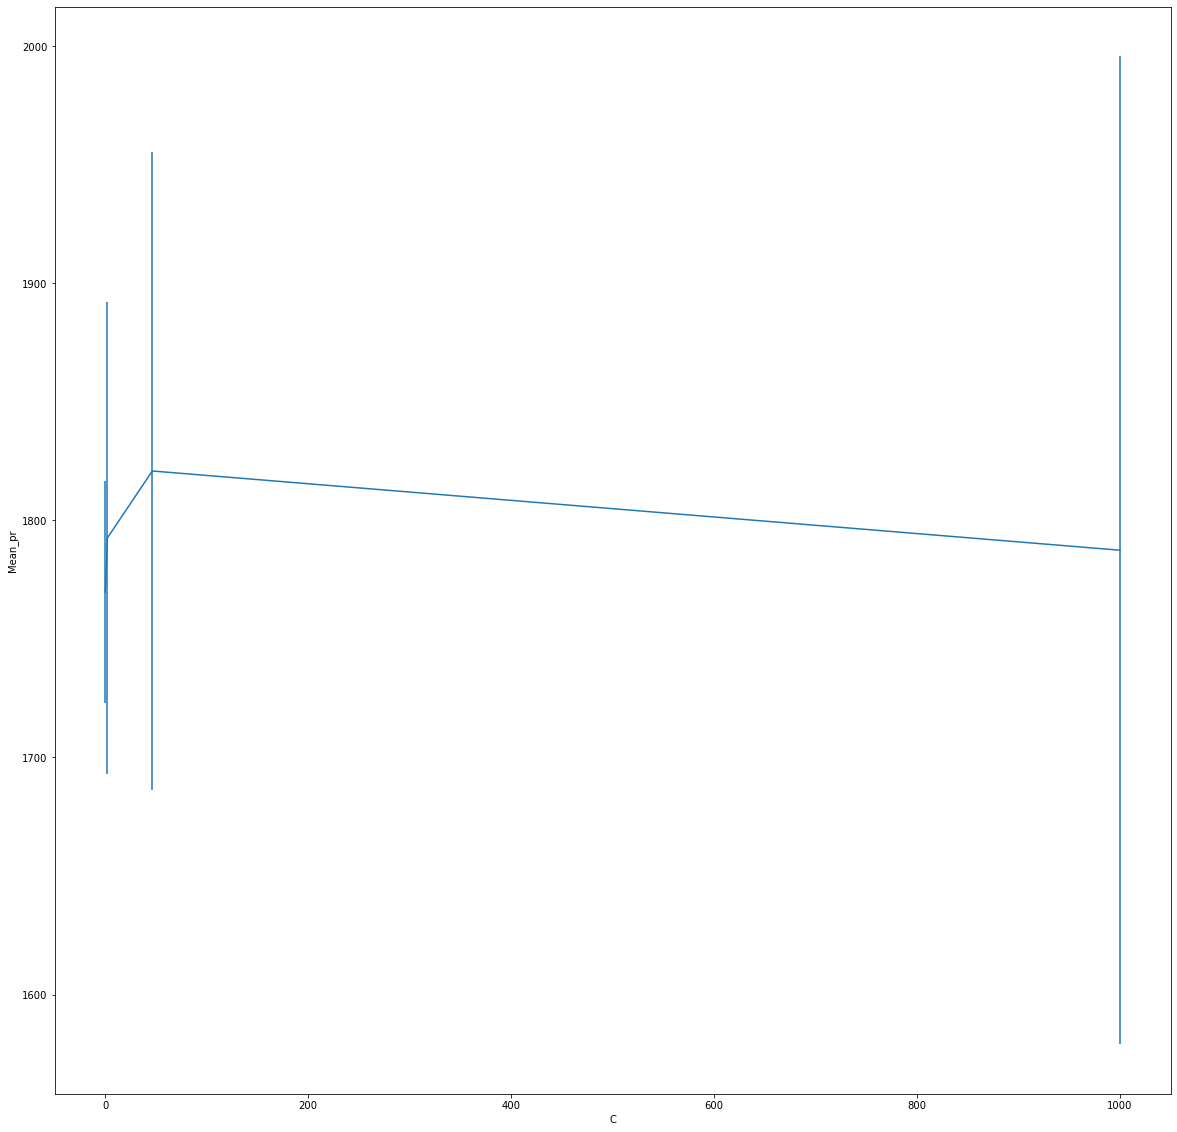

In [142]:
plt.figure(figsize=(20, 20))
plt.errorbar(c, avg_profit , std)
plt.xlabel('C')
plt.ylabel('Mean_pr')

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [143]:
#your code here
from sklearn.metrics import precision_score,recall_score

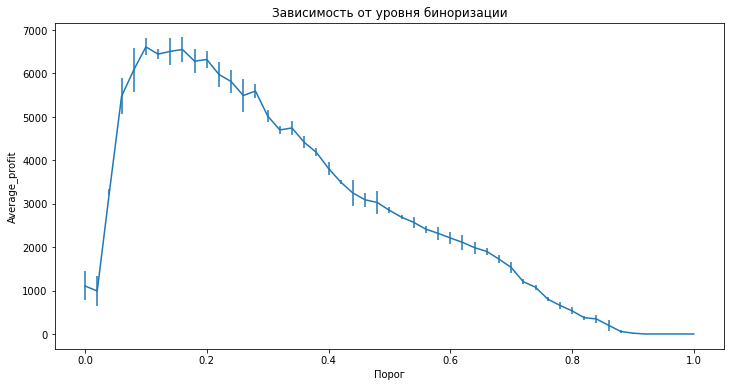

In [147]:
std=[]
avg_profit=[]
barier = []

for threshold in np.linspace(0, 1, 51):
    revenues=[]
    costs=[]
    profit=[]

    cross = KFold(n_splits=3, shuffle=True)
    for train_index, test_index in cross.split(X):
        X_train_kf, X_test_kf = X[train_index,:], X[test_index,:]
        y_train_kf, y_test_kf = y[train_index], y[test_index]


        log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs' ).fit(X_train_kf, y_train_kf)
        test_prediction = log_reg.predict_proba(X_test_kf)[:,1]>threshold

        z = np.sum(np.random.randint(20, size=y_test_kf.shape)*y_test_kf*test_prediction)
        revenues.append(z)
        costs.append(np.sum(test_prediction))
        profit.append(np.sum(z-np.sum(test_prediction)))

    barier.append(threshold)
    avr_profit=np.mean(profit)
    std_profit=np.std(profit)
    std.append(std_profit)
    avg_profit.append(avr_profit)
fig, ax = plt.subplots(figsize = (12,6))

ax.errorbar(barier, avg_profit , std)
ax.set_xlabel('Порог')
ax.set_ylabel('Average_profit')
ax.set_title('Зависимость от уровня биноризации')


plt.show()

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [ ]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__

In [76]:
summa

3